In [40]:
import pandas as pd
import matplotlib.pyplot as plt

city_info = pd.read_csv('City.csv')
cab_data = pd.read_csv('Cab_Data.csv')
customer_info = pd.read_csv('Customer_ID.csv')
transaction = pd.read_csv('Transaction_ID.csv')

merged_data = pd.merge(cab_data, transaction, on='Transaction ID')
merged_data = pd.merge(merged_data, customer_info, on='Customer ID')


In [41]:
merged_data['Income Class'] = pd.cut(merged_data['Income (USD/Month)'],
                            bins=[0, 3500, 15000, float('inf')],
                            labels=['Low Income', 'Middle Income', 'High Income'])
merged_data['Profit'] = merged_data['Price Charged'] - merged_data['Cost of Trip']

In [42]:
print(merged_data.shape)

(359392, 14)


### Hypothesis 1:
The companies are profitting every year.

Value already converted to date value


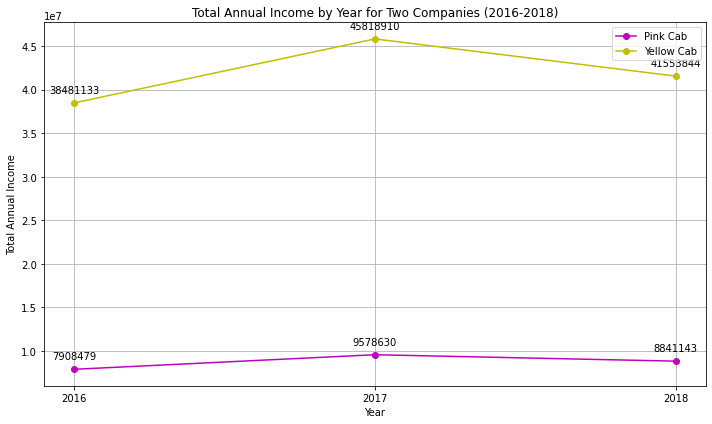

In [65]:
# Analysis total company income annually for both company
from datetime import datetime, timedelta

# function borrowed from https://stackoverflow.com/questions/29387137/how-to-convert-a-given-ordinal-number-from-excel-to-a-date/29387450#29387450
def from_excel_ordinal(ordinal: float, _epoch0=datetime(1899, 12, 31)) -> datetime:
    if ordinal >= 60:
        ordinal -= 1  # Excel leap year bug, 1900 is not a leap year!
    return (_epoch0 + timedelta(days=ordinal)).replace(microsecond=0)

try:
    merged_data['Date of Travel'] = merged_data['Date of Travel'].apply(from_excel_ordinal)
except TypeError:
    print('Value already converted to date value')
grouped_data = merged_data.groupby([merged_data['Date of Travel'].dt.year, 'Company'])['Price Charged'].sum().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
plt.plot(grouped_data.index, grouped_data['Pink Cab'], label='Pink Cab', marker='o', color='m')
plt.plot(grouped_data.index, grouped_data['Yellow Cab'], label='Yellow Cab', marker='o', color='y')
plt.xlabel('Year')
plt.ylabel('Total Annual Income')
plt.title('Total Annual Income by Year for Two Companies (2016-2018)')
plt.xticks(grouped_data.index)
plt.legend()

for year, company_a, company_b in zip(grouped_data.index, grouped_data['Pink Cab'], grouped_data['Yellow Cab']):
    plt.annotate(f'{company_a:.0f}', (year, company_a), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{company_b:.0f}', (year, company_b), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.tight_layout()
plt.show()


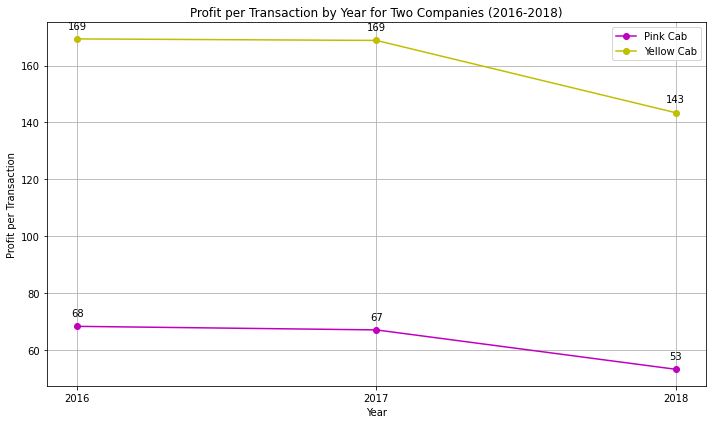

In [66]:
# Profit per Transaction by year
grouped_data = merged_data.groupby([merged_data['Date of Travel'].dt.year, 'Company'])['Profit'].mean().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
plt.plot(grouped_data.index, grouped_data['Pink Cab'], label='Pink Cab', marker='o', color='m')
plt.plot(grouped_data.index, grouped_data['Yellow Cab'], label='Yellow Cab', marker='o', color='y')
plt.xlabel('Year')
plt.ylabel('Profit per Transaction')
plt.title('Profit per Transaction by Year for Two Companies (2016-2018)')
plt.xticks(grouped_data.index)
plt.legend()

for year, company_a, company_b in zip(grouped_data.index, grouped_data['Pink Cab'], grouped_data['Yellow Cab']):
    plt.annotate(f'{company_a:.0f}', (year, company_a), textcoords="offset points", xytext=(0,10), ha='center')
    plt.annotate(f'{company_b:.0f}', (year, company_b), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.tight_layout()
plt.show()

Observation:\
We can observe an up-curve from 2016 to 2017 and a down-curve from 2017 to 2018 for both companies.
There is a sharper increase and a steady decrease for Yellow Cab.\
The overall increase for Yellow Cab is greater then Pink Cab.

### Hypothesis 2:
There is a relationship between gender and company profits.

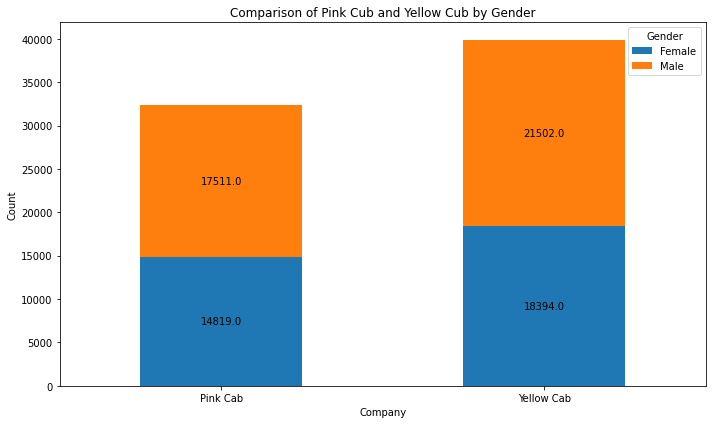

In [44]:
# Compare number of customer from Yellow Cab to Pink Cab while splitting the counts by gender
# drop duplicated Customer from Company and Gender group
merged_data_no_duplicates = merged_data.drop_duplicates(subset=['Company', 'Gender', 'Customer ID'])
grouped_data = merged_data_no_duplicates.groupby(['Company', 'Gender']).size().unstack(fill_value=0)

ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Company')
plt.ylabel('Count')
plt.title('Comparison of Pink Cub and Yellow Cub by Gender')
plt.xticks(rotation=0)
plt.legend(title='Gender', labels=['Female', 'Male'])
for i in ax.containers:
    ax.bar_label(i,label_type='center', labels=i.datavalues)
plt.tight_layout()
plt.show()


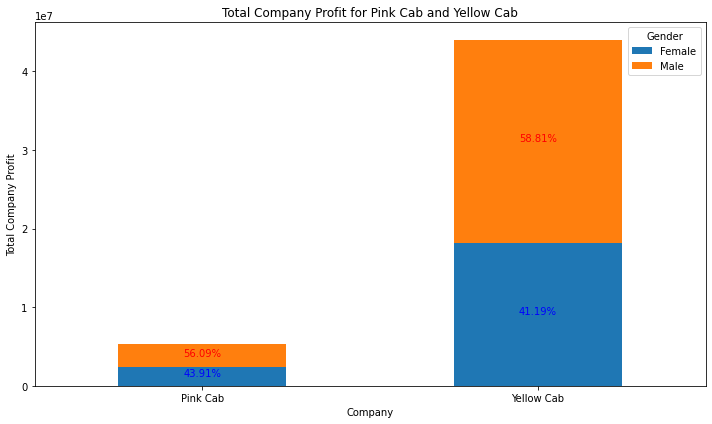

In [45]:
# Count the percentage of tributes of each gender in both companies
grouped_data = merged_data.groupby(['Company', 'Gender'])['Profit'].sum().unstack(fill_value=0)

ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Company')
plt.ylabel('Total Company Profit')
plt.title('Total Company Profit for Pink Cab and Yellow Cab')
plt.xticks(rotation=0)
plt.legend(title='Gender', labels=['Female', 'Male'])
for i, company in enumerate(grouped_data.index):
    total = grouped_data.loc[company].sum()
    female_percentage = (grouped_data.loc[company, 'Female'] / total) * 100
    male_percentage = (grouped_data.loc[company, 'Male'] / total) * 100

    ax.text(i, grouped_data.loc[company, 'Female'] / 2, f'{female_percentage:.2f}%', ha='center', color='blue', fontsize=10)
    ax.text(i, (grouped_data.loc[company, 'Female'] + total) / 2, f'{male_percentage:.2f}%', ha='center', color='red', fontsize=10)
plt.tight_layout()
plt.show()

Observations:\
There is a close number of unique users for both company.\
In Pink Cab company, Male users contribute 12.18% more than Female users to the total company income.\
In Yellow Cab company, Male users contribute 17.62% more than Female users to the total company income.

### Hypothesis 3:
Upper income class travel by cab more and contributes more in the total profit.

Company            Pink Cab     Yellow Cab
Income Class                              
Low Income      51415911524   168009798507
Middle Income  390857946567  1269066160246
High Income    423806172488  1370103814598


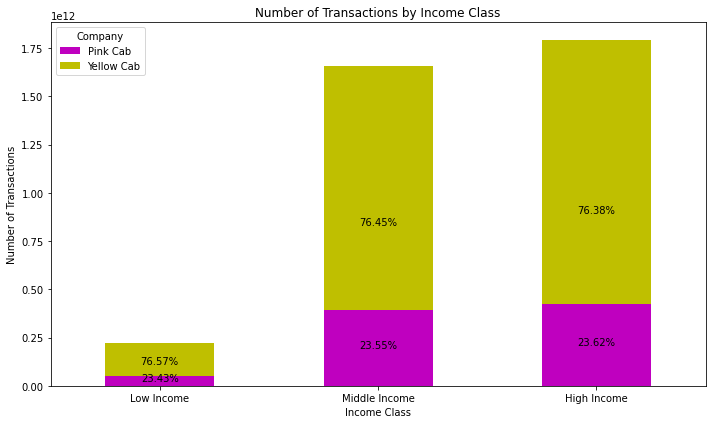

In [76]:
# Count the total transaction number for each income class
income_class_data = merged_data.groupby(['Income Class', 'Company'])['Transaction ID'].sum().unstack(fill_value=0)

ax = income_class_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['m', 'y'])
plt.xlabel('Income Class')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Income Class')
plt.xticks(rotation=0)
for i, classes in enumerate(income_class_data.index):
    total = income_class_data.loc[classes].sum()
    Pink_percentage = (income_class_data.loc[classes, 'Pink Cab'] / total) * 100
    Yellow_percentage = (income_class_data.loc[classes, 'Yellow Cab'] / total) * 100

    ax.text(i, income_class_data.loc[classes, 'Pink Cab'] / 2, f'{Pink_percentage:.2f}%', ha='center', color='black', fontsize=10)
    ax.text(i, total / 2, f'{Yellow_percentage:.2f}%', ha='center', color='black', fontsize=10)
plt.tight_layout()
plt.show()

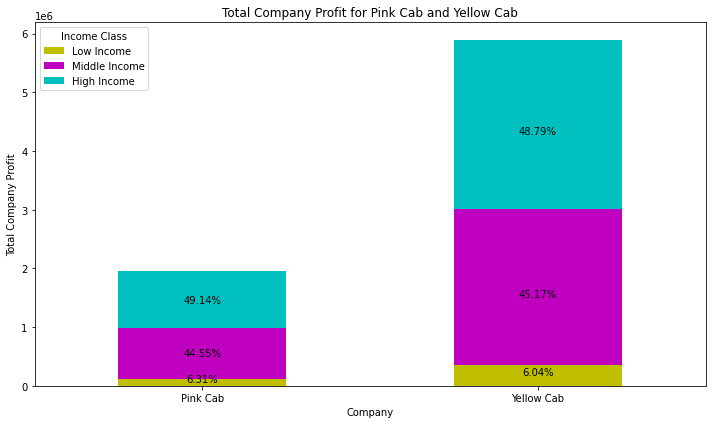

In [47]:
# The percentage of tributes of each income class in both companies
merged_data_no_duplicates = merged_data.drop_duplicates(subset=['Company', 'Income Class', 'Customer ID'])
grouped_data = merged_data_no_duplicates.groupby(['Company', 'Income Class'])['Profit'].sum().unstack(fill_value=0)

ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['y', 'm', 'c'])
plt.xlabel('Company')
plt.ylabel('Total Company Profit')
plt.title('Total Company Profit for Pink Cab and Yellow Cab')
plt.xticks(rotation=0)
plt.legend(title='Income Class', labels=['Low Income', 'Middle Income', 'High Income'])

for i, company in enumerate(grouped_data.index):
    total = grouped_data.loc[company].sum()
    H_percentage = (grouped_data.loc[company, 'High Income'] / total) * 100
    M_percentage = (grouped_data.loc[company, 'Middle Income'] / total) * 100
    L_percentage = (grouped_data.loc[company, 'Low Income'] / total) * 100

    ax.text(i, grouped_data.loc[company, 'Low Income'] / 2, f'{L_percentage:.2f}%', ha='center', color='black', fontsize=10)
    ax.text(i, (grouped_data.loc[company, 'Low Income'] + grouped_data.loc[company, 'Middle Income']) / 2, f'{M_percentage:.2f}%', ha='center', color='black', fontsize=10)
    ax.text(i, (grouped_data.loc[company, 'Middle Income'] + total) / 2, f'{H_percentage:.2f}%', ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()

Observations:\
Number of transactions from High_income class and Middle_income class is close. But there are not much transactions from Low_income class.\
For Pink Cab, users from High_income class contribute 4% more than Middle_income class and both classes contribute 94.06% of the total profits.\
For Yellow Cab,  users from High_income class contribute 4.01% more than Middle_income class and both classes contribute 94.03% of the total profits.\
People from all three income classes choose Cab company equally.

### Hypothesis 4:
Longer distance trip leads to higher tips.

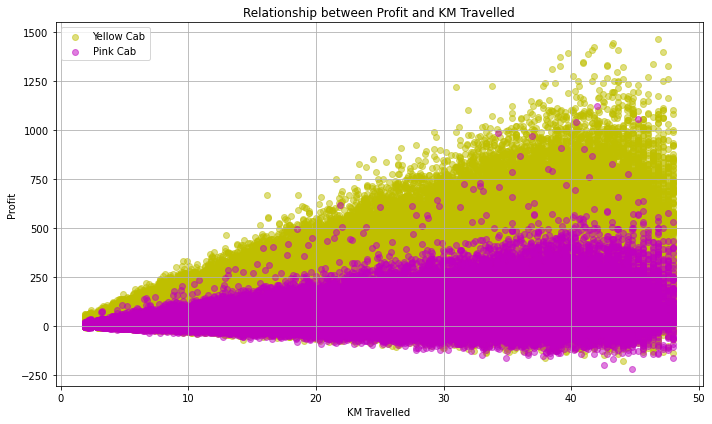

In [48]:
# Count the difference between price charged and cost of trip as tips
# find the relation in Tips and KM travelled while split by company
yellow_cab_data = merged_data[merged_data['Company'] == 'Yellow Cab']
pink_cab_data = merged_data[merged_data['Company'] == 'Pink Cab']

plt.figure(figsize=(10, 6))
plt.scatter(yellow_cab_data['KM Travelled'], yellow_cab_data['Profit'], alpha=0.5, label='Yellow Cab', color='y')
plt.scatter(pink_cab_data['KM Travelled'], pink_cab_data['Profit'], alpha=0.5, label='Pink Cab', color='m')
plt.xlabel('KM Travelled')
plt.ylabel('Profit')
plt.title('Relationship between Profit and KM Travelled')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Observations:\
There is a positive relartionship between the difference of 'Profit' and 'KM Travelled'. Longer distance of travel lead to greater difference between 'Price Charged' and 'Cost of Trip'.\
There are difference below 0. We interpret that as a result of using discounts.\
Yellow Cab users tend to pay more tips than Pink Cab users.

### Hypothesis 5:
Users in some cities tend to prefer card more than cash. 

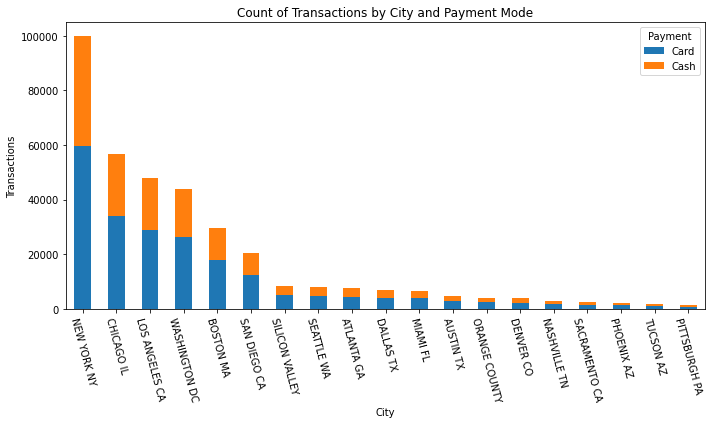

In [49]:
# Payments in each city 
grouped_data = merged_data.groupby(['City', 'Payment_Mode']).size().unstack(fill_value=0)
sorted_cities = grouped_data.sum(axis=1).sort_values(ascending=False).index
grouped_data = grouped_data.loc[sorted_cities]

grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('City')
plt.ylabel('Transactions')
plt.title('Count of Transactions by City and Payment Mode')
plt.xticks(rotation=-75)
plt.legend(title='Payment')
plt.tight_layout()
plt.show()

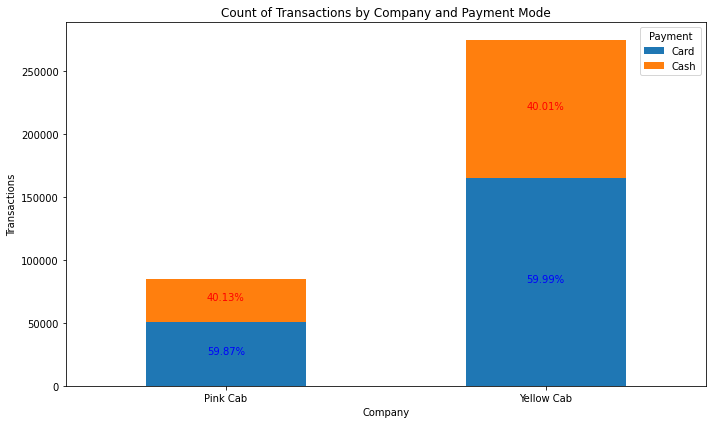

In [50]:
# Payments in each company 
grouped_data = merged_data.groupby(['Company', 'Payment_Mode']).size().unstack(fill_value=0)

ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Company')
plt.ylabel('Transactions')
plt.title('Count of Transactions by Company and Payment Mode')
plt.xticks(rotation=0)
plt.legend(title='Payment')
for i, company in enumerate(grouped_data.index):
    total = grouped_data.loc[company].sum()
    Card_percentage = (grouped_data.loc[company, 'Card'] / total) * 100
    Cash_percentage = (grouped_data.loc[company, 'Cash'] / total) * 100

    ax.text(i, grouped_data.loc[company, 'Card'] / 2, f'{Card_percentage:.2f}%', ha='center', color='blue', fontsize=10)
    ax.text(i, (grouped_data.loc[company, 'Card'] + total) / 2, f'{Cash_percentage:.2f}%', ha='center', color='red', fontsize=10)
plt.tight_layout()
plt.show()

Observations:\
Most Cities have more Card payment than Cash.\
Both companies users perfer Card than Cash.\
NY has an outstanding Transaction numbers comparing to other cities. 

### Hypothesis 6:
Number of city users has positive relation to city population. 

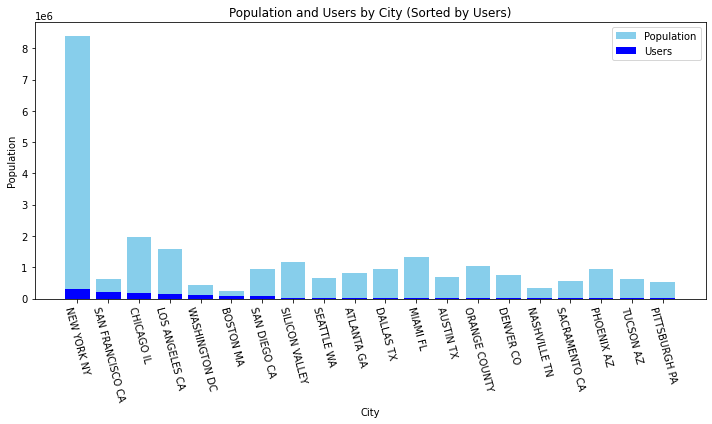

In [51]:
# convert str to number
try:
    city_info['Population'] = city_info['Population'].str.replace(',', '').astype(int)
    city_info['Users'] = city_info['Users'].str.replace(',', '').astype(int)
except AttributeError:
    print('Value already converted to Int')

city_info_sorted = city_info.sort_values(by='Users', ascending=False)
# users in each city vs. population in each city
plt.figure(figsize=(10, 6))
plt.bar(city_info_sorted['City'], city_info_sorted['Population'], label='Population', color='skyblue')
plt.bar(city_info_sorted['City'], city_info_sorted['Users'], label='Users', color='blue')
plt.xlabel('City')
plt.ylabel('Population')
plt.title('Population and Users by City (Sorted by Users)')
plt.xticks(rotation=-75)
plt.legend()
plt.tight_layout()
plt.show()

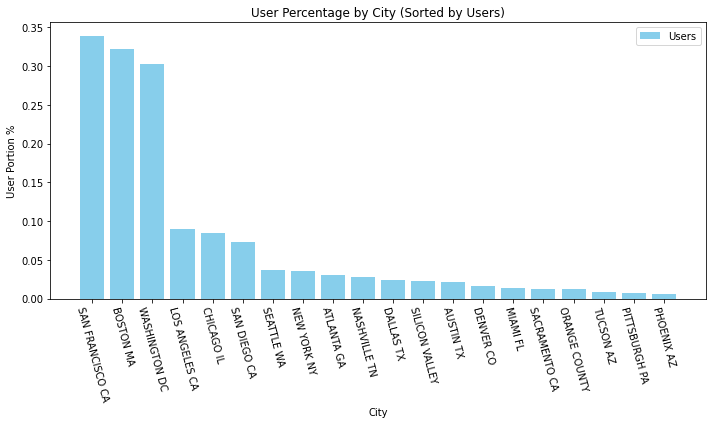

In [52]:
# percentage of users in a city
city_info['User_Portion'] = city_info['Users'] / city_info['Population']

city_info_sorted = city_info.sort_values(by='User_Portion', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(city_info_sorted['City'], city_info_sorted['User_Portion'], label='Users', color='skyblue')
plt.xlabel('City')
plt.ylabel('User Portion %')
plt.title('User Percentage by City (Sorted by Users)')
plt.xticks(rotation=-75)
plt.legend()
plt.tight_layout()
plt.show()

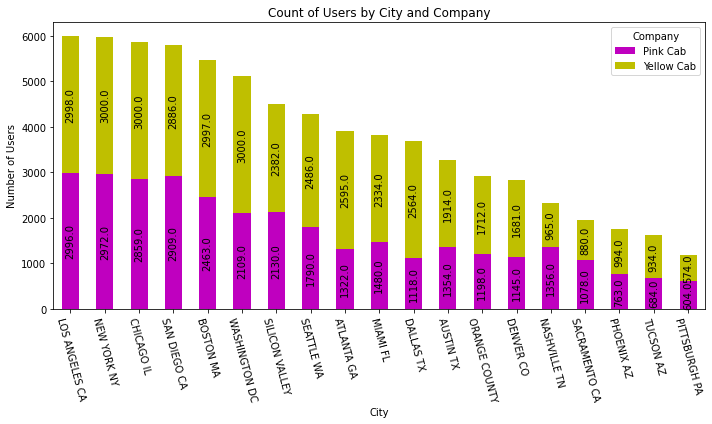

In [53]:
# Number of users and company portion in each city
merged_data_no_duplicates = merged_data.drop_duplicates(subset=['Company', 'City', 'Customer ID'])
grouped_data = merged_data_no_duplicates.groupby(['City','Company']).size().unstack(fill_value=0)
sorted_cities = grouped_data.sum(axis=1).sort_values(ascending=False).index
grouped_data = grouped_data.loc[sorted_cities]

ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['m', 'y'])
plt.xlabel('City')
plt.ylabel('Number of Users')
plt.title('Count of Users by City and Company')
plt.xticks(rotation=-75)
plt.legend(title='Company')
for i in ax.containers:
    ax.bar_label(i,label_type='center', labels=i.datavalues, rotation=90)
plt.tight_layout()
plt.show()

Observations:\
City with large population does not always lead to more users.\
Three outstanding cities, SAN FRANCISCO, BOSTON, and WASHINGTON, have higher user portions, though they do not own a large population.\
Although NEW YORK has the most users, the percentage of users is not high as the population is also very large. \
There is no Transaction data from SAN FRANCISCO.\
In formentioned outstanding cities and NEW YORK, Yellow Cab has more users than Pink Cab.


### Hypothesis 7:
Good company has better user retention rates.

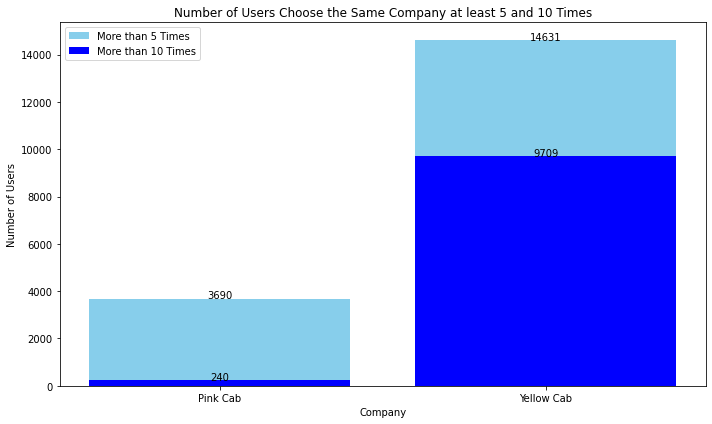

In [54]:
# Number of customers choosing the same company for more than 5 times and 10 times
customer_company_counts = merged_data.groupby(['Customer ID', 'Company']).size().reset_index(name='Counts')
greater_than_5 = customer_company_counts.groupby('Company')['Counts'].apply(lambda x: (x > 5).sum()).reset_index()
greater_than_10 = customer_company_counts.groupby('Company')['Counts'].apply(lambda x: (x > 10).sum()).reset_index()

grouped_data = pd.merge(greater_than_5, greater_than_10, on='Company')
grouped_data.columns = ['Company', 'Customers_Count_5', 'Customers_Count_10']

plt.figure(figsize=(10, 6))
plt.bar(grouped_data['Company'], grouped_data['Customers_Count_5'], label='More than 5 Times', color='skyblue')
plt.bar(grouped_data['Company'], grouped_data['Customers_Count_10'], label='More than 10 Times', color='blue')
plt.xlabel('Company')
plt.ylabel('Number of Users')
plt.title('Number of Users Choose the Same Company at least 5 and 10 Times')
plt.xticks(rotation=0)
for i, company in enumerate(grouped_data.index):
    total = grouped_data.loc[company, 'Customers_Count_5']
    plt.text(i, grouped_data.loc[company, 'Customers_Count_10'], grouped_data.loc[company, 'Customers_Count_10'], ha='center', color='black', fontsize=10)
    plt.text(i, total, total, ha='center', color='black', fontsize=10)
plt.legend()
plt.tight_layout()
plt.show()


Observations:\
There is only a small number of users use Pink Cab for more than 10 times.\
Users choose to use Yellow Cab for more than 5 times are also likely to choose it for more than 10 times.\
In both case that a user choose the same company for more than 5 times and 10 times, Yellow Cab is doing better than Pink Cab.


### Recommendations:
Based on the observations from data, we will recommend Yellow Cab.